Copyright 2019, Pavel Eftimovski, All rights reserved.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn
import missingno as msno
import matplotlib.pyplot as plt
import datetime as dt
import urllib.parse
from importlib import reload 
import ipynb.fs.full.USAID_support_functions as psf
reload(psf)
%matplotlib inline

# import USAID Supply chain Pricing Data 
scsp_data = pd.read_excel('.../USAID_Data/USAID_SCSP_Data.xlsx')
scsp_data.shape

# get an example of the look of the dataset
scsp_data.head()

# Rename column names so they are more suitable to work with
new_column_names = ['id', 'p_code',
                    'pq', 'po_so',
                    'asn_dn',
                    'country',
                    'managed_by',
                    'flf_via',
                    'vendor_terms',
                    'ship_mode',
                    'pq_client_date',
                    'po_vendor_date',
                    'sch_del_date',
                    'del_date',
                    'rec_del_date',
                    'product_grp',
                    'sub_class',
                    'vendor',
                    'itm_desc',
                    'mol_test',
                    'brand',
                    'dosage',
                    'dos_form',
                    'unit_msr',
                    'ln_itm_qty',
                    'ln_itm_val',
                    'pack_price',
                    'unit_price',
                    'manu_site',
                    'first_line',
                    'weight',
                    'freight_cost',
                    'line_item']

newcol_dict = dict(zip(scsp_data.columns, new_column_names))
scsp_data.rename(columns=(newcol_dict), inplace =True)

# get the names of the columns of the dataset
list(scsp_data.columns.values)

# check if duplicate row exists
scsp_data.duplicated().sum()

list(scsp_data.columns.values)
scsp_data.dtypes

id                         int64
p_code                    object
pq                        object
po_so                     object
asn_dn                    object
country                   object
managed_by                object
flf_via                   object
vendor_terms              object
ship_mode                 object
pq_client_date            object
po_vendor_date            object
sch_del_date      datetime64[ns]
del_date          datetime64[ns]
rec_del_date      datetime64[ns]
product_grp               object
sub_class                 object
vendor                    object
itm_desc                  object
mol_test                  object
brand                     object
dosage                    object
dos_form                  object
unit_msr                   int64
ln_itm_qty                 int64
ln_itm_val               float64
pack_price               float64
unit_price               float64
manu_site                 object
first_line                object
weight    

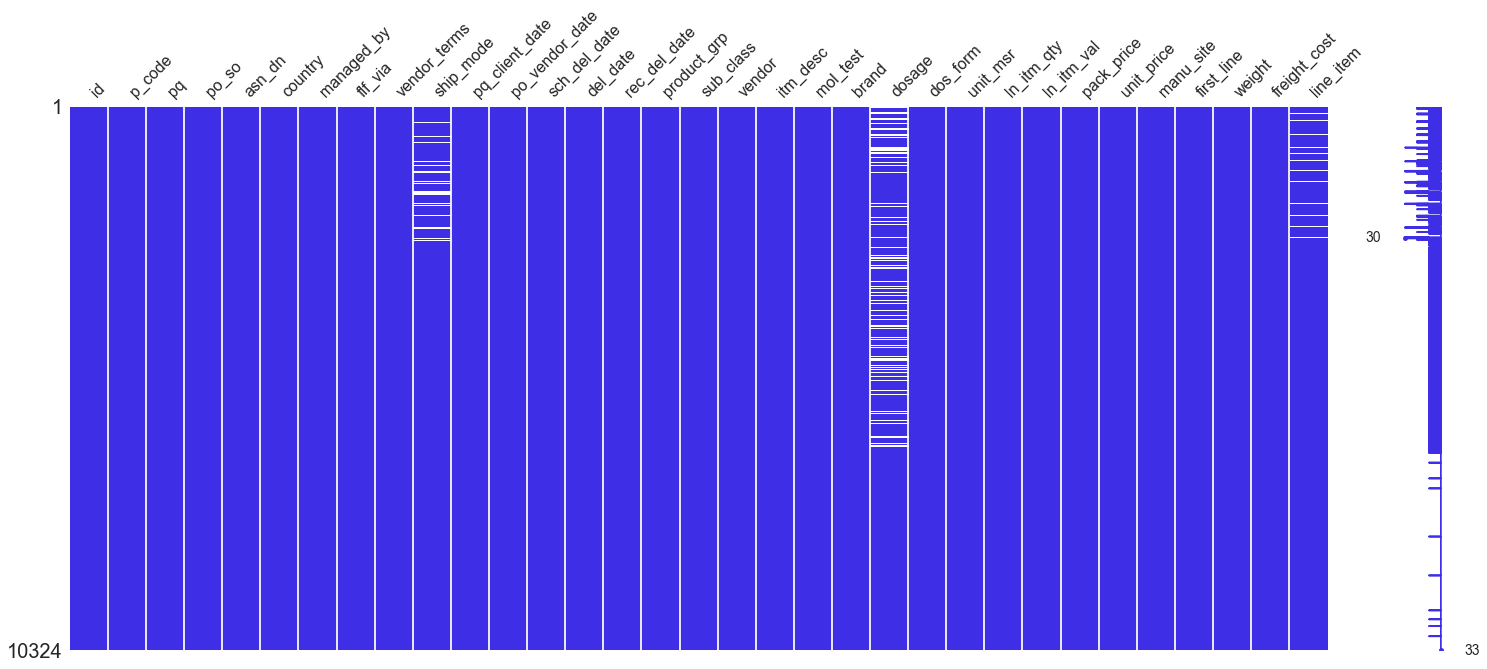

In [3]:
# check for missing values
msno.matrix(scsp_data, color=(62/255,47/255,231/255))

In [4]:
# generate blocks od columns from same data type
scms_path = '.../USAID_Data/USAID_SCSP_Data.xlsx'
segments = psf.sort_by_type(scms_path)

segments.keys()

Type: float64 , Count: 4 
Column name and null counts: 
ln_itm_val      0
pack_price      0
unit_price      0
line_item     287
dtype: int64

Type: int64 , Count: 3 
Column name and null counts: 
id            0
unit_msr      0
ln_itm_qty    0
dtype: int64

Type: datetime64[ns] , Count: 3 
Column name and null counts: 
sch_del_date    0
del_date        0
rec_del_date    0
dtype: int64

Type: object , Count: 23 
Column name and null counts: 
p_code               0
pq                   0
po_so                0
asn_dn               0
country              0
managed_by           0
flf_via              0
vendor_terms         0
ship_mode          360
pq_client_date       0
po_vendor_date       0
product_grp          0
sub_class            0
vendor               0
itm_desc             0
mol_test             0
brand                0
dosage            1736
dos_form             0
manu_site            0
first_line           0
weight               0
freight_cost         0
dtype: int64



ipynb.fs.full.USAID_support_functions:31: FutureWarning: as_blocks is deprecated and will be removed in a future version


dict_keys(['float64', 'int64', 'datetime64[ns]', 'object'])

In [5]:
float64, int64, datetime64, tobject = [s for s in segments.values()]

print(float64.shape, int64.shape, datetime64.shape, tobject.shape)

(10324, 4) (10324, 3) (10324, 3) (10324, 23)


In [6]:
## Fix missing values in 'dosage' column ##

# check for possible null values in related columns
possible_nulls = tobject[[ 'itm_desc', 'mol_test', 'brand', 'dos_form', 'dosage' ]].groupby(
                                        [ 'itm_desc', 'mol_test', 'brand','dos_form']).max()

possible_nulls[possible_nulls.dosage.isnull()].reset_index().dos_form.value_counts()

Test kit                37
Test kit - Ancillary     9
Name: dos_form, dtype: int64

In [7]:
# write 'TestKit/Ancillary' instead of NAN, since it is a test kit and it can not have dosage amount
tobject = psf.replace_nan(tobject, 'dosage', 'TestKit/Ancillary')

-Before: 
 ship_mode     360
dosage       1736
dtype: int64

-After: 
 ship_mode    360
dtype: int64


In [8]:
# check the filled-in places
print(tobject['dosage'])

0        TestKit/Ancillary
1                  10mg/ml
2        TestKit/Ancillary
3                    150mg
4                     30mg
5                  10mg/ml
6                    200mg
7                    200mg
8                     30mg
9                 200/50mg
10                200/50mg
11       TestKit/Ancillary
12       TestKit/Ancillary
13               150/300mg
14       TestKit/Ancillary
15                   200mg
16       TestKit/Ancillary
17       TestKit/Ancillary
18                      2g
19       TestKit/Ancillary
20       TestKit/Ancillary
21                   200mg
22                 10mg/ml
23                200/50mg
24       TestKit/Ancillary
25       TestKit/Ancillary
26       TestKit/Ancillary
27       TestKit/Ancillary
28       TestKit/Ancillary
29                    30mg
               ...        
10294        150/300/200mg
10295              30/60mg
10296             200/50mg
10297              30/60mg
10298        150/300/200mg
10299            300/300mg
1

In [9]:
## Fix null values in 'shipment mode' ##

# describe columns against ship_mode column
psf.nan_desc(tobject, 'ship_mode')


-------
 count            360
unique            15
top       110-ZM-T01
freq              99
Name: p_code, dtype: object

-------
 count                360
unique                 1
top       Pre-PQ Process
freq                 360
Name: pq, dtype: object

-------
 count            360
unique           220
top       SCMS-16600
freq              18
Name: po_so, dtype: object

-------
 count          360
unique         226
top       ASN-1520
freq            16
Name: asn_dn, dtype: object

-------
 count               360
unique               12
top       Côte d'Ivoire
freq                113
Name: country, dtype: object

-------
 count          360
unique           1
top       PMO - US
freq           360
Name: managed_by, dtype: object

-------
 count          360
unique           2
top       From RDC
freq           312
Name: flf_via, dtype: object

-------
 count                360
unique                 5
top       N/A - From RDC
freq                 312
Name: vendor_terms, dtype: obje

In [10]:
# count values 
tobject[tobject.ship_mode.isnull()].reset_index().dos_form.value_counts()

Tablet                                126
Tablet - FDC                           65
Capsule                                56
Test kit                               46
Oral solution                          37
Oral suspension                         9
Tablet - FDC + co-blister               6
Test kit - Ancillary                    5
Delayed-release capsules - blister      4
Chewable/dispersible tablet             4
Powder for oral solution                2
Name: dos_form, dtype: int64

In [11]:
data, column, groupby = [tobject.copy(), 'ship_mode',['country', 'itm_desc', 'ship_mode']]

# declare column X
colX=data.groupby(groupby).agg('count').reset_index()[['country', 'itm_desc', 'ship_mode']]
print("-colX shape: ",colX.shape, colX.columns)

colX = colX.groupby(['country', 'itm_desc']).min().reset_index()

# declare column Y
colY = pd.merge(data, colX, how='left', left_on=['country', 'itm_desc']
                    , right_on=['country', 'itm_desc'], suffixes=('','_y'))

print("-colY shape before: ",colY.shape)

# assign ship_mode in colY to ship_mode without null values
colY['ship_mode'] = colY.ship_mode.where(colY.ship_mode.notnull(), colY.ship_mode_y)

# find null values
still_null= colY.ship_mode.isnull().index 

# assign 
c = data.ship_mode.value_counts()/data.ship_mode.value_counts().sum()
for i in still_null:
    colY.loc[i,'ship_mode'] = np.random.choice([j for j in c.index], p=[a for a in c])
colY.ship_mode.isnull().sum()

# drop column Y
colY.drop('ship_mode_y', axis=1, inplace=True)
print("-colY shape after: ",colY.shape)
tobject= colY.copy()

-colX shape:  (1323, 3) Index(['country', 'itm_desc', 'ship_mode'], dtype='object')
-colY shape before:  (10324, 24)
-colY shape after:  (10324, 23)


In [12]:
## Fix null values in 'line_item' ##
float64.isnull().sum()

year = pd.Series([str(x).split("-")[0] for x in datetime64.sch_del_date], 
               index = datetime64.sch_del_date.index)

line_itm_null = tobject[float64.line_item.isnull()]

# most missing values are in year 2007, therefore:
# use Median Value from 2007, to fill null values
p = np.percentile(float64[year == '2007'].dropna()['line_item'], 0.5)

# fill null values
float64.fillna(value=p, inplace=True)
scsp_data['line_item'].fillna(value=p, inplace=True)
print(float64)

       ln_itm_val  pack_price  unit_price   line_item
0          551.00       29.00        0.97     0.00245
1         6200.00        6.20        0.03     0.00245
2        40000.00       80.00        0.80     0.00245
3       127360.80        3.99        0.07     0.00245
4       121600.00        3.20        0.05     0.00245
5         2225.60        5.35        0.02     0.00245
6         4374.00       32.40        0.36     0.00245
7        60834.55        3.65        0.06     0.00245
8          532.35        1.95        0.03     0.00245
9       115080.00       41.10        0.34     0.00245
10      115080.00       41.10        0.34     0.00245
11      100000.00       40.00        2.00     0.00245
12         850.00       85.00        0.85     0.00245
13       99800.00        9.98        0.17     0.00245
14       60000.00       80.00        0.80     0.00245
15       14764.50       25.50        0.42     0.00245
16      120000.00       80.00        0.80   192.00000
17       33000.00       16.5

In [13]:
### INVESTIGATE MISPLACED FEATURES ###

# find misplaced features
tobject.info()

tobject[['pq_client_date', 'po_vendor_date']].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 23 columns):
p_code            10324 non-null object
pq                10324 non-null object
po_so             10324 non-null object
asn_dn            10324 non-null object
country           10324 non-null object
managed_by        10324 non-null object
flf_via           10324 non-null object
vendor_terms      10324 non-null object
ship_mode         10324 non-null object
pq_client_date    10324 non-null object
po_vendor_date    10324 non-null object
product_grp       10324 non-null object
sub_class         10324 non-null object
vendor            10324 non-null object
itm_desc          10324 non-null object
mol_test          10324 non-null object
brand             10324 non-null object
dosage            10324 non-null object
dos_form          10324 non-null object
manu_site         10324 non-null object
first_line        10324 non-null object
weight            10324 non-null object
freight_cos

,pq_client_date,po_vendor_date
count,10324,10324
unique,765,897
top,Pre-PQ Process,N/A - From RDC
freq,2476,5404


In [14]:
# check if there are unique values in form of a string/nan values
for row in ['pq_client_date', 'po_vendor_date']:
    print("\n- Not date format for {}: {}".format
          (row,[c for c in tobject[row].unique() if type(c) == str]))


- Not date format for pq_client_date: ['Pre-PQ Process', 'Date Not Captured']

- Not date format for po_vendor_date: ['Date Not Captured', 'N/A - From RDC']


Text(0.5, 1.0, '15 Most frequent categories in: po_vendor_date')

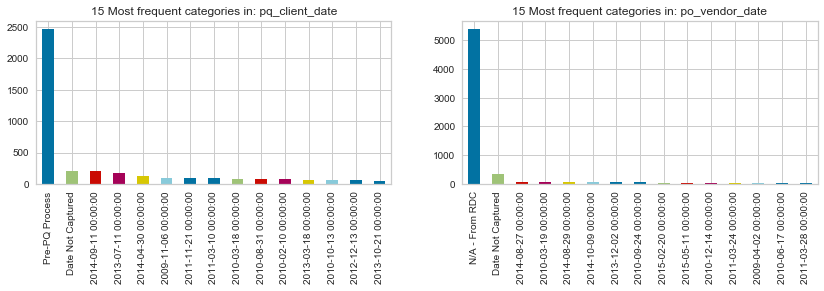

In [15]:
# plot the most frequent categories in 'pq_client_date' and 'po_vendor_date'
get_axis, (axis1, axis2) = plt.subplots(1,2, figsize=(14,3))
scsp_data['pq_client_date'].value_counts()[:15].plot(kind='bar', orientation='vertical', ax=axis1)
axis1.set_title("15 Most frequent categories in: pq_client_date")
scsp_data['po_vendor_date'].value_counts()[:15].plot(kind='bar', orientation='vertical', ax=axis2)
axis2.set_title("15 Most frequent categories in: po_vendor_date")

In [16]:
# replace the nan values with dummy year values
date64_copy, tobject_copy = datetime64.copy(), tobject.copy()

tobject_copy.po_vendor_date.replace({'Date Not Captured':pd.to_datetime('2000')
                    , 'N/A - From RDC':pd.to_datetime('2001')}, inplace=True)

tobject_copy.pq_client_date.replace({'Date Not Captured':pd.to_datetime('1990')
                    , 'Pre-PQ Process':pd.to_datetime('1991'),}, inplace=True)

print("-Before: ", "\ndatetime64 copy shape: ", date64_copy.shape, "\ntboject copy shape: ", tobject_copy.shape)

# move pq_client_date and po_vendor_date from tobject to datetime64
for col in ['pq_client_date', 'po_vendor_date']:
    date64_copy[col] = pd.to_datetime(tobject_copy[col])
    tobject_copy.drop(col, axis=1, inplace=True)
    
print("\n-After: ", "\ndatetime64 copy shape: ", date64_copy.shape, "\ntboject copy shape: ", tobject_copy.shape)

-Before:  
datetime64 copy shape:  (10324, 3) 
tboject copy shape:  (10324, 23)

-After:  
datetime64 copy shape:  (10324, 5) 
tboject copy shape:  (10324, 21)


In [17]:
# estimate difference (in days) between sch_del_date and pq_date/po_date
pq_po_dates =['pq_client_date','po_vendor_date'] 

for c in pq_po_dates:
    date64_copy[c+"_est"] = pd.to_numeric(date64_copy['sch_del_date']-date64_copy[c])/(1e9*3600*24.0)    
print("\n Value:",date64_copy.describe())


 Value:        pq_client_date_est  po_vendor_date_est
count        10324.000000        10324.000000
mean          1797.887931         2142.746222
std           2751.609771         1939.888080
min           -150.000000         -160.000000
25%            127.000000          105.750000
50%            196.000000         2542.000000
75%           5896.000000         3955.500000
max           7358.000000         5477.000000


In [18]:
# count dummy values for PO and PQ dates
po_2000 = list(date64_copy[date64_copy.po_vendor_date=='2000'].index)
po_2001 = list(date64_copy[date64_copy.po_vendor_date=='2001'].index)

pq_1990 = list(date64_copy[date64_copy.pq_client_date=='1990'].index)
pq_1991 = list(date64_copy[date64_copy.pq_client_date=='1991'].index)

print("Count PO dummy values: ",len(set(po_2000+po_2001)))
print("Count PQ dummy values: ",len(set(pq_1990+pq_1991)))

# add country, vendor, item description and year variables for clarification
date64_copy = pd.merge(date64_copy, tobject_copy[['country', 'vendor', 'itm_desc']], how="left"
                       , right_index=True, left_index=True)
date64_copy['year'] = [x.year for x in date64_copy.sch_del_date]
print(date64_copy.columns)

Count PO dummy values:  5732
Count PQ dummy values:  2681
Index(['sch_del_date', 'del_date', 'rec_del_date', 'pq_client_date',
       'po_vendor_date', 'pq_client_date_est', 'po_vendor_date_est', 'country',
       'vendor', 'itm_desc', 'year'],
      dtype='object')


In [19]:
## po_vendor_date Manipulation ##
print("\n-Before \nMean:\n ", date64_copy.mean())

# drop columns with dummy values
date64_drop= date64_copy.drop(po_2000 + po_2001, axis=0)
print("\n-After \nMean:\n ",date64_drop.mean())

# group by country/year
po_group = date64_drop.groupby(['country','year']).agg('mean').reset_index()
po_group_yr = date64_drop.groupby(['year']).agg('mean').reset_index()


-Before 
Mean:
  pq_client_date_est    1797.887931
po_vendor_date_est    2142.746222
year                  2011.257555
dtype: float64

-After 
Mean:
  pq_client_date_est    1195.207753
po_vendor_date_est     105.742596
year                  2011.851699
dtype: float64


In [20]:
# merge date64_copy with po_group
print(date64_copy.loc[po_2000 + po_2001,'po_vendor_date'].value_counts()) #count of po_2000/2001

merge1 =pd.merge(date64_copy, po_group, left_on=['country','year'],
        right_on=['country', 'year'], how='left')

print("\nNull values count: ",merge1['po_vendor_date_est_y'].isnull().sum())

# merge 'merge1' with po_group_yr
merge2 =pd.merge(merge1, po_group_yr, left_on=['year'],
        right_on=['year'], how='left')
print("\nNull values count: ",merge2['po_vendor_date_est'].isnull().sum())

print(merge2[['sch_del_date',
              'del_date',
              'rec_del_date',
              'pq_client_date',
              'po_vendor_date',
              'pq_client_date_est_x',
              'po_vendor_date_est_x',
              'pq_client_date_est_y',
              'po_vendor_date_est_y',
              'pq_client_date_est',
              'po_vendor_date_est']].head())

# assign date64_copy to merge2
date64_copy = merge2[['sch_del_date',
                      'del_date',
                      'rec_del_date',
                      'pq_client_date',
                      'po_vendor_date',
                      'pq_client_date_est_x',
                      'po_vendor_date_est_x',
                      'pq_client_date_est_y',
                      'po_vendor_date_est_y',
                      'pq_client_date_est',
                      'po_vendor_date_est']]

2001-01-01    5404
2000-01-01     328
Name: po_vendor_date, dtype: int64

Null values count:  153

Null values count:  0
  sch_del_date   del_date rec_del_date pq_client_date po_vendor_date  \
0   2006-06-02 2006-06-02   2006-06-02     1991-01-01     2000-01-01   
1   2006-11-14 2006-11-14   2006-11-14     1991-01-01     2000-01-01   
2   2006-08-27 2006-08-27   2006-08-27     1991-01-01     2000-01-01   
3   2006-09-01 2006-09-01   2006-09-01     1991-01-01     2000-01-01   
4   2006-08-11 2006-08-11   2006-08-11     1991-01-01     2000-01-01   

   pq_client_date_est_x  po_vendor_date_est_x  pq_client_date_est_y  \
0                5631.0                2344.0                5656.0   
1                5796.0                2509.0                   NaN   
2                5717.0                2430.0                5656.0   
3                5722.0                2435.0                   NaN   
4                5701.0                2414.0                   NaN   

   po_vendor_date_e

In [21]:
# new estimates for po_vendor_date
date64_copy['po_date_diff'] = date64_copy.loc[:,'po_vendor_date_est_x']

print("->po_vendor_date_est description: \n")
print("Total values: {}, \npo_vendor_date_est_x: {}, \npo_vendor_date_est_y: {}, Null values: {}".format(
                                            len(date64_copy.po_date_diff),
                                            sum(date64_copy.po_date_diff==date64_copy.po_vendor_date_est_x), 
                                            sum(date64_copy.po_date_diff==date64_copy.po_vendor_date_est_y), 
                                            date64_copy.po_date_diff.isnull().sum()))

d1 = date64_copy.loc[:,'po_date_diff'] < 2000
date64_copy['po_date_diff'].where(d1,date64_copy.po_vendor_date_est_y,inplace=True)

print("\n->po_vendor_date_est<2000 description: \n")
print("Total values: {}, \npo_vendor_date_est_x: {}, \npo_vendor_date_est_y: {}, Null values: {}".format(
                                            len(date64_copy.po_date_diff),
                                            sum(date64_copy.po_date_diff==date64_copy.po_vendor_date_est_x), 
                                            sum(date64_copy.po_date_diff==date64_copy.po_vendor_date_est_y), 
                                            date64_copy.po_date_diff.isnull().sum()))

# rest of nan values manipulation
d2 = date64_copy.loc[:,'po_date_diff'].notnull()

date64_copy['po_date_diff'].where(d2,date64_copy.po_vendor_date_est,inplace=True)

print("\n->po_vendor_date_est.notnull description: \n")
print("Total values: {},\npo_vendor_date_est_y: {}, Null values: {}".format(
                                            len(date64_copy.po_date_diff),
                                            sum(date64_copy.po_date_diff==date64_copy.po_vendor_date_est), 
                                            date64_copy.po_date_diff.isnull().sum()))

# assign new column for po_date
date64_copy['po_new_date'] = (date64_copy.loc[:,'sch_del_date'])-date64_copy.loc[:,'po_date_diff'].apply(pd.Timedelta)
print("\n->po_new_date null values count: ", date64_copy.po_new_date.isnull().sum())

->po_vendor_date_est description: 

Total values: 10324, 
po_vendor_date_est_x: 10324, 
po_vendor_date_est_y: 23, Null values: 0


C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pavel\Miniconda3\lib\site-packages\pandas\core\generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)



->po_vendor_date_est<2000 description: 

Total values: 10324, 
po_vendor_date_est_x: 4592, 
po_vendor_date_est_y: 5602, Null values: 153

->po_vendor_date_est.notnull description: 

Total values: 10324,
po_vendor_date_est_y: 153, Null values: 0

->po_new_date null values count:  0


C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
## pq_client_date Manipulation ##

date64_copy['pq_date_diff'] = date64_copy.loc[:,'pq_client_date_est_x']
pq_mean = date64_copy.drop(pq_1990+pq_1991, axis=0).loc[:,'pq_date_diff'].mean()

print("-pq_client_date_est_x mean: ",date64_copy.pq_client_date_est_x.mean())
print("-pq_mean mean after drop pq_1990+pq_1991: ", pq_mean)

s = date64_copy.loc[:,'pq_date_diff'] < 2000

#pq_date_diff is the average of pq_client_date_est_x
date64_copy['pq_date_diff'] = date64_copy.loc[:,'pq_date_diff'].where(s,pq_mean)  

# pq_new_date column is assigned corresponding to the value in po_new_date
date64_copy['pq_new_date'] = date64_copy.po_new_date - date64_copy.loc[:,'pq_date_diff'].apply(pd.Timedelta)

print("-\ndate64_copy mean by column: \n", date64_copy.mean())

datetime64 = date64_copy.loc[:,['sch_del_date',
                                'del_date',
                                'rec_del_date',
                                'pq_client_date',
                                'po_vendor_date',
                                'po_new_date',
                                'pq_new_date']]

C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


-pq_client_date_est_x mean:  1797.8879310344828
-pq_mean mean after drop pq_1990+pq_1991:  172.24349077587334
-
date64_copy mean by column: 
 pq_client_date_est_x    1797.887931
po_vendor_date_est_x    2142.746222
pq_client_date_est_y    1630.023172
po_vendor_date_est_y     104.242352
pq_client_date_est      1678.031581
po_vendor_date_est       102.549427
po_date_diff             103.797796
pq_date_diff             172.243491
dtype: float64


In [23]:
## Weight and Freight Cost Manipulation ##

print(scsp_data.dtypes) # we can see they are from 'object' type, but need to be numeric

id                         int64
p_code                    object
pq                        object
po_so                     object
asn_dn                    object
country                   object
managed_by                object
flf_via                   object
vendor_terms              object
ship_mode                 object
pq_client_date            object
po_vendor_date            object
sch_del_date      datetime64[ns]
del_date          datetime64[ns]
rec_del_date      datetime64[ns]
product_grp               object
sub_class                 object
vendor                    object
itm_desc                  object
mol_test                  object
brand                     object
dosage                    object
dos_form                  object
unit_msr                   int64
ln_itm_qty                 int64
ln_itm_val               float64
pack_price               float64
unit_price               float64
manu_site                 object
first_line                object
weight    

In [24]:
# explore freight_cost and weight 
fc_w = ['freight_cost','weight']
for column in fc_w:
    tobject[column]=tobject[column].apply(lambda x: pd.to_numeric(x, errors = 'ignore'))
    print("\nType Counts for: {}, \n{}".format(column,
        pd.Series([type(x) for x in tobject['freight_cost']]).value_counts()))
    
print(len(fc_w))


Type Counts for: freight_cost, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
dtype: int64

Type Counts for: weight, 
<class 'float'>    5734
<class 'str'>      4126
<class 'int'>       464
dtype: int64
2


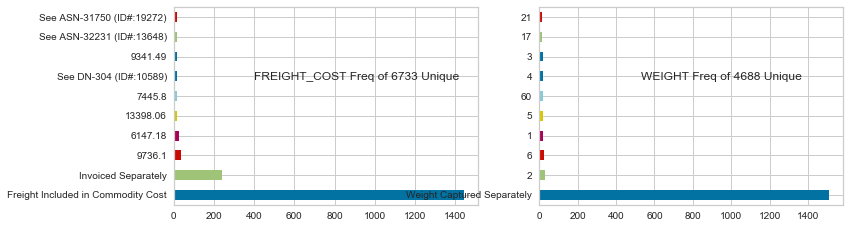

In [25]:
# most frequent unique categories from each column
lngth = len(fc_w)/2+1
plt.figure(figsize=(12,lngth*4))
occrs = 10

for i in range(len(fc_w)):
    plt.subplot(lngth,2,i+1)
    unique = len(tobject[fc_w[i]].value_counts())
    header = fc_w[i].upper() + " Freq of " + str(unique) + " Unique"
    if occrs == -1:
        tobject[fc_w[i]].value_counts().plot()
    else:
        tobject[fc_w[i]].value_counts()[:occrs].plot(kind='barh', orientation='horizontal')
    plt.title(header,x=0.6,y=0.6)

In [26]:
# futher exploration .. 
tobject[tobject['freight_cost'] == 'Freight Included in Commodity Cost'].head()

,p_code,pq,po_so,asn_dn,country,managed_by,flf_via,vendor_terms,ship_mode,pq_client_date,...,vendor,itm_desc,mol_test,brand,dosage,dos_form,manu_site,first_line,weight,freight_cost
6,110-ZM-T01,Pre-PQ Process,SCMS-139,ASN-130,Zambia,PMO - US,Direct Drop,DDU,Air,Pre-PQ Process,...,MERCK SHARP & DOHME IDEA GMBH (FORMALLY MERCK ...,"Efavirenz 200mg [Stocrin/Sustiva], capsule, 90...",Efavirenz,Stocrin/Sustiva,200mg,Capsule,MSD South Granville Australia,Yes,328,Freight Included in Commodity Cost
9,110-ZM-T01,Pre-PQ Process,SCMS-165,ASN-199,Zambia,PMO - US,Direct Drop,CIP,Truck,Pre-PQ Process,...,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),"Lopinavir/Ritonavir 200/50mg [Aluvia], tablets...",Lopinavir/Ritonavir,Aluvia,200/50mg,Tablet,ABBVIE (Abbott) St. P'burg USA,Yes,643,Freight Included in Commodity Cost
10,110-ZM-T01,Pre-PQ Process,SCMS-221,ASN-223,Zambia,PMO - US,Direct Drop,CIP,Air,Pre-PQ Process,...,ABBVIE LOGISTICS (FORMERLY ABBOTT LOGISTICS BV),"Lopinavir/Ritonavir 200/50mg [Aluvia], tablets...",Lopinavir/Ritonavir,Aluvia,200/50mg,Tablet,ABBVIE Ludwigshafen Germany,Yes,643,Freight Included in Commodity Cost
15,113-ZW-T01,Pre-PQ Process,SCMS-308,ASN-285,Zimbabwe,PMO - US,Direct Drop,CIP,Air,Pre-PQ Process,...,BRISTOL-MYERS SQUIBB,"#102198**Didanosine 200mg [Videx], tablets, 60...",Didanosine,Videx,200mg,Tablet,"BMS Meymac, France",Yes,Weight Captured Separately,Freight Included in Commodity Cost
16,102-NG-T01,Pre-PQ Process,SCMS-354,ASN-608,Nigeria,PMO - US,Direct Drop,CIP,Air,Pre-PQ Process,...,ACCOUN NIGERIA LIMITED,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,TestKit/Ancillary,Test kit,ABBVIE GmbH & Co.KG Wiesbaden,Yes,Weight Captured Separately,Freight Included in Commodity Cost


In [27]:
tobject[tobject['weight'] == 'Weight Captured Separately'].head()

,p_code,pq,po_so,asn_dn,country,managed_by,flf_via,vendor_terms,ship_mode,pq_client_date,...,vendor,itm_desc,mol_test,brand,dosage,dos_form,manu_site,first_line,weight,freight_cost
12,102-NG-T01,Pre-PQ Process,SCMS-230,ASN-144,Nigeria,PMO - US,Direct Drop,EXW,Truck,Pre-PQ Process,...,EY Laboratories,"HIV 1/2, InstantChek HIV 1+2 Kit, 100 Tests","HIV 1/2, InstantChek HIV 1+2 Kit",InstantCHEK,TestKit/Ancillary,Test kit,"EY Laboratories, USA",Yes,Weight Captured Separately,Invoiced Separately
15,113-ZW-T01,Pre-PQ Process,SCMS-308,ASN-285,Zimbabwe,PMO - US,Direct Drop,CIP,Air,Pre-PQ Process,...,BRISTOL-MYERS SQUIBB,"#102198**Didanosine 200mg [Videx], tablets, 60...",Didanosine,Videx,200mg,Tablet,"BMS Meymac, France",Yes,Weight Captured Separately,Freight Included in Commodity Cost
16,102-NG-T01,Pre-PQ Process,SCMS-354,ASN-608,Nigeria,PMO - US,Direct Drop,CIP,Air,Pre-PQ Process,...,ACCOUN NIGERIA LIMITED,"HIV 1/2, Determine Complete HIV Kit, 100 Tests","HIV 1/2, Determine Complete HIV Kit",Determine,TestKit/Ancillary,Test kit,ABBVIE GmbH & Co.KG Wiesbaden,Yes,Weight Captured Separately,Freight Included in Commodity Cost
31,116-ZA-T01,Pre-PQ Process,SCMS-14050,ASN-1251,South Africa,PMO - US,Direct Drop,DDP,Air,Pre-PQ Process,...,"JSI R&T INSTITUTE, INC.","Zidovudine 10mg/ml [Retrovir], oral solution, ...",Zidovudine,Retrovir,10mg/ml,Oral solution,GSK Mississauga (Canada),Yes,Weight Captured Separately,Freight Included in Commodity Cost
35,123-NG-T01,Pre-PQ Process,SCMS-15550,ASN-1269,Nigeria,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,"Orgenics, Ltd","HIV, Lancet, Safety, for HIV Test kits, 100 Pcs","HIV, Lancet, Safety, for HIV Test kits, 100 Pcs",Generic,TestKit/Ancillary,Test kit - Ancillary,Inverness Japan,Yes,Weight Captured Separately,Invoiced Separately


In [28]:
# fix weight:
# group by shipment number (asn/dn) - batches of shipments or single ones
batched_asndn =tobject.groupby('asn_dn').filter(lambda x: len(x)>1)
unbatched_asndn = tobject.groupby('asn_dn').filter(lambda x: len(x)==1)

# separate weight according to the most frequent occurency
sep_w_batched = batched_asndn[batched_asndn.weight== 'Weight Captured Separately']
print("-Shape of batched separate weight: ",sep_w_batched.shape)
sep_w_unbatched = unbatched_asndn[unbatched_asndn.weight== 'Weight Captured Separately']
print("-Shape of single separate weight: ",sep_w_unbatched.shape)

-Shape of batched separate weight:  (1042, 23)
-Shape of single separate weight:  (465, 23)


In [29]:
# seperate out the single, top and bottom items from weight
single_w = unbatched_asndn.drop(list(sep_w_unbatched.index),axis=0)
print("-Single items in Weight Shape: ",single_w.shape)

nosep_w_batched = batched_asndn.drop(list(sep_w_batched.index),axis=0)

top_w = nosep_w_batched[[type(x)==int for x in nosep_w_batched.weight]]
print("-Top items in Weight Shape: ",top_w.shape)

bottom_w = nosep_w_batched.drop(top_w.index)
print("-Bottom items in Weight Shape:",bottom_w.shape)

-Single items in Weight Shape:  (5115, 23)
-Top items in Weight Shape:  (1257, 23)
-Bottom items in Weight Shape: (2445, 23)


In [30]:
dict_w = single_w.loc[:,['itm_desc','weight','mol_test', 'dos_form']]
dict_w['weight'] = pd.to_numeric(dict_w.loc[:,'weight'])
dict_w['ln_itm_qty'] = int64.loc[list(dict_w.index),:]['ln_itm_qty']
dict_w['unit_msr'] = int64.loc[list(dict_w.index),:]['unit_msr']
dict_w['itm_weight'] = dict_w.weight/dict_w.ln_itm_qty

# group by corresponding features
dict_w_itm = dict_w.groupby('itm_desc').mean().reset_index()[['itm_desc', 'itm_weight']]
dict_w_mol = dict_w.groupby('mol_test').mean().reset_index()[['mol_test', 'itm_weight']]
dict_w_df = dict_w.groupby('dos_form').mean().reset_index()[['dos_form', 'itm_weight']]

# merge by corresponding features
merge_itm = pd.merge(tobject, dict_w_itm, how='left', left_on='itm_desc', right_on='itm_desc')
merge_mol = pd.merge(merge_itm, dict_w_mol, how='left', left_on='mol_test', right_on='mol_test')
merge_df = pd.merge(merge_mol, dict_w_df, how='left', left_on='dos_form', right_on='dos_form')

print("Check-point: ", merge_itm.shape, merge_mol.shape, merge_df.shape)

Check-point:  (10324, 24) (10324, 25) (10324, 26)


In [31]:
merge_nn = merge_df.itm_weight_x.notnull()
merge_df['new_w'] =merge_df.itm_weight_x.where(merge_nn, merge_df.itm_weight_y)

merge_nn2 = merge_df.new_w.notnull()
merge_df['new_w'] = merge_df.new_w.where(merge_nn2, merge_df.itm_weight)

print("Left over nulls: ", merge_df.new_w.isnull().sum())

tobject = merge_df[['p_code',
                    'pq',
                    'po_so',
                    'asn_dn',
                    'country',
                    'managed_by',
                    'flf_via',
                    'vendor_terms',
                    'ship_mode',
                    'pq_client_date',
                    'po_vendor_date',
                    'product_grp',
                    'sub_class',
                    'vendor',
                    'itm_desc',
                    'mol_test',
                    'brand',
                    'dosage',
                    'dos_form',
                    'manu_site',
                    'first_line',
                    'weight',
                    'freight_cost',
                    'new_w']]

float64['real_w'] = int64.loc[:,'ln_itm_qty']*tobject.loc[:,'new_w']
tobject.drop(['new_w'], axis=1, inplace=True)
print("\nDescription: \n")
float64.info()

Left over nulls:  0

Description: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 5 columns):
ln_itm_val    10324 non-null float64
pack_price    10324 non-null float64
unit_price    10324 non-null float64
line_item     10324 non-null float64
real_w        10324 non-null float64
dtypes: float64(5)
memory usage: 403.4 KB


C:\Users\Pavel\Miniconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
# fix freight_cost:
tobject.freight_cost.value_counts()[:8]

Freight Included in Commodity Cost    1442
Invoiced Separately                    239
9736.1                                  36
6147.18                                 27
13398.06                                16
7445.8                                  16
See DN-304 (ID#:10589)                  16
9341.49                                 15
Name: freight_cost, dtype: int64

In [33]:
#separate freight cost data according to two most frequent occurences
separate_fc_batches = batched_asndn[batched_asndn.freight_cost== 'Invoiced Separately']
print("-Shape of separate freight cost batches: ", separate_fc_batches.shape)

separate_fc_unbatched = unbatched_asndn[unbatched_asndn.freight_cost== 'Invoiced Separately']
print("-Shape of single separate freight cost: ", separate_fc_unbatched.shape)

batched_fc_commodity = batched_asndn[batched_asndn.freight_cost== 'Freight Included in Commodity Cost']
print("-Shape of batched freight cost in commodity cost: ", batched_fc_commodity.shape)

unbatched_fc_commodity = unbatched_asndn[unbatched_asndn.freight_cost== 'Freight Included in Commodity Cost']
print("-Shape of single freight cost in commodity cost: ", unbatched_fc_commodity.shape)

-Shape of separate freight cost batches:  (58, 23)
-Shape of single separate freight cost:  (181, 23)
-Shape of batched freight cost in commodity cost:  (1000, 23)
-Shape of single freight cost in commodity cost:  (442, 23)


In [34]:
# Seperate out the single, topline and bottom items from freight cost
single_itms = unbatched_asndn.drop(list(unbatched_fc_commodity.index),axis=0)
print("only single: ",single_itms.shape)

bundled_no_sep_weight = batched_asndn.drop(list(batched_fc_commodity.index),axis=0)
top_itms = bundled_no_sep_weight[[type(x)==int for x in bundled_no_sep_weight.weight]]
print("only topline: ",top_itms.shape)

bottom_itms = bundled_no_sep_weight.drop(top_itms.index)
print("only bottom items :",bottom_itms.shape)

only single:  (5138, 23)
only topline:  (1234, 23)
only bottom items : (2510, 23)


In [35]:
fc_dict = single_w.loc[:,['itm_desc','freight_cost','mol_test', 'dos_form']]
fc_dict['freight_cost'] = pd.to_numeric(fc_dict.loc[:,'freight_cost'], errors='coerce')
fc_dict['real_w'] = float64.loc[list(fc_dict.index),:]['real_w']
fc_dict['itm_freight_cost'] = fc_dict.loc[:,'freight_cost']/fc_dict.loc[:,'real_w']

# group by corresponding features
fc_dict_itm = fc_dict.groupby('itm_desc').mean().reset_index()[['itm_desc', 'itm_freight_cost']]
fc_dict_mol = fc_dict.groupby('mol_test').mean().reset_index()[['mol_test', 'itm_freight_cost']]
fc_dict_df = fc_dict.groupby('dos_form').mean().reset_index()[['dos_form', 'itm_freight_cost']]

# merge
fmerge_itm = pd.merge(tobject, fc_dict_itm, how='left', left_on='itm_desc', right_on='itm_desc') 
fmerge_mol = pd.merge(fmerge_itm, fc_dict_mol, how='left', left_on='mol_test', right_on='mol_test')
fmerge_df = pd.merge(fmerge_mol, fc_dict_df, how='left', left_on='dos_form', right_on='dos_form')

print("Freight cost check-point: ", fmerge_itm.shape, fmerge_mol.shape, fmerge_df.shape)

Freight cost check-point:  (10324, 24) (10324, 25) (10324, 26)


In [36]:
merge_ff = fmerge_df.itm_freight_cost_x.notnull()
fmerge_df['new_fc'] =fmerge_df.itm_freight_cost_x.where(merge_ff ,fmerge_df.itm_freight_cost_y)

merge_ff2 = fmerge_df.new_fc.notnull()
fmerge_df['new_fc'] = fmerge_df.new_fc.where(merge_ff2, fmerge_df.itm_freight_cost)
print("Left over nulls: ", fmerge_df.new_fc.isnull().sum())

tobject = fmerge_df[['p_code',
                     'pq',
                     'po_so',
                     'asn_dn',
                     'country',
                     'managed_by',
                     'flf_via',
                     'vendor_terms',
                     'ship_mode',
                     'pq_client_date',
                     'po_vendor_date',
                     'product_grp',
                     'sub_class',
                     'vendor',
                     'itm_desc',
                     'mol_test',
                     'brand',
                     'dosage',
                     'dos_form',
                     'manu_site',
                     'first_line',
                     'weight',
                     'freight_cost',
                     'new_fc']]

float64['real_fc'] = float64.loc[:,'real_w']*tobject.loc[:,'new_fc']
tobject.drop(['new_fc'], axis=1, inplace=True)
print("\nDescription: \n")
float64.info()

Left over nulls:  0

Description: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10324 entries, 0 to 10323
Data columns (total 6 columns):
ln_itm_val    10324 non-null float64
pack_price    10324 non-null float64
unit_price    10324 non-null float64
line_item     10324 non-null float64
real_w        10324 non-null float64
real_fc       10324 non-null float64
dtypes: float64(6)
memory usage: 484.0 KB


In [37]:
### FEATURE EXTRACTION ###

# engineer features for year, month, day
ext_col =['pq_new_date',
          'po_new_date',
          'sch_del_date',
          'del_date',
          'rec_del_date']

year_l=[list(datetime64[column].dt.year) for column in ext_col] 
mnth_l=[list(datetime64[column].dt.month) for column in ext_col] 
day_l=[list(datetime64[column].dt.day) for column in ext_col] 

date = [year_l, mnth_l, day_l]
suffixes = ['yr', 'mn', 'dy']

for col in ext_col:
    j = ext_col.index(col)
    for i in range(len(date)):
        col_name = str(col)+str("_")+str(suffixes[i])
        # convert to categorical variable
        tobject[col_name] = pd.Categorical(date[i][j])
tobject.info()

C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 38 columns):
p_code             10324 non-null object
pq                 10324 non-null object
po_so              10324 non-null object
asn_dn             10324 non-null object
country            10324 non-null object
managed_by         10324 non-null object
flf_via            10324 non-null object
vendor_terms       10324 non-null object
ship_mode          10324 non-null object
pq_client_date     10324 non-null object
po_vendor_date     10324 non-null object
product_grp        10324 non-null object
sub_class          10324 non-null object
vendor             10324 non-null object
itm_desc           10324 non-null object
mol_test           10324 non-null object
brand              10324 non-null object
dosage             10324 non-null object
dos_form           10324 non-null object
manu_site          10324 non-null object
first_line         10324 non-null object
weight             10324 non-n

In [38]:
# engineer features for business day, week of year, and quarter
ext_col =['pq_new_date',
          'po_new_date',
          'sch_del_date',
          'del_date',
          'rec_del_date']

wd_l=[list(datetime64[column].dt.weekday) for column in ext_col] 
wy_l=[list(datetime64[column].dt.weekofyear) for column in ext_col] 
q_l=[list(datetime64[column].dt.quarter) for column in ext_col] 

periods = [wd_l, wy_l, q_l]
suffixes = ['wd', 'wk', 'qt']

for col in ext_col:
    j = ext_col.index(col)
    for i in range(len(periods)):
        col_name = str(col)+str("_")+str(suffixes[i])
        # convert to categorical variable
        tobject[col_name] = pd.Categorical(periods[i][j])
tobject.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 53 columns):
p_code             10324 non-null object
pq                 10324 non-null object
po_so              10324 non-null object
asn_dn             10324 non-null object
country            10324 non-null object
managed_by         10324 non-null object
flf_via            10324 non-null object
vendor_terms       10324 non-null object
ship_mode          10324 non-null object
pq_client_date     10324 non-null object
po_vendor_date     10324 non-null object
product_grp        10324 non-null object
sub_class          10324 non-null object
vendor             10324 non-null object
itm_desc           10324 non-null object
mol_test           10324 non-null object
brand              10324 non-null object
dosage             10324 non-null object
dos_form           10324 non-null object
manu_site          10324 non-null object
first_line         10324 non-null object
weight             10324 non-n

In [39]:
# concatenate numeric description for medicine item
item_desc = pd.concat([int64, float64], axis=1)
print("New look of int64+float64:"); 
item_desc.head()

New look of int64+float64:


,id,unit_msr,ln_itm_qty,ln_itm_val,pack_price,unit_price,line_item,real_w,real_fc
0,1,30,19,551.0,29.00,0.97,0.00245,13.000000,819.935000
1,3,240,1000,6200.0,6.20,0.03,0.00245,368.830071,2335.540207
2,4,100,500,40000.0,80.00,0.80,0.00245,10671.152042,92778.636389
3,15,60,31920,127360.8,3.99,0.07,0.00245,1916.285060,856061.478787
4,16,60,38000,121600.0,3.20,0.05,0.00245,3159.972544,73767.191447


In [40]:
# new list for populating from exam_col
exam_col = ['country',
            'vendor',
            'manu_site',
            'mol_test',
            'brand'] 

new_pop = [None,None,None,None,None]

# new list for populating from num_col
num_col = ['ln_itm_qty',
           'ln_itm_val',
           'line_item',
           'real_w',
           'real_fc']

new_pop2 =[None,None,None,None,None]

# populate new_pop from exam_col
for i in range(len(exam_col)):
    new_pop[i] = pd.concat([tobject,item_desc[num_col]], axis=1).groupby(
        [exam_col[i], 'sch_del_date_yr']).agg(['sum', 'count', 'mean'])
    new_pop[i].columns = [exam_col[i]+"_"+str(x[0]+x[1]).split("_")[-1] for x in new_pop[i].columns]
    new_pop[i].reset_index(inplace=True)    

print([pop.columns for pop in new_pop])

# populate new_pop2 from num_col
for i in range(len(exam_col)):
    obj = tobject[exam_col+['sch_del_date_yr']].copy()
    new_pop2[i] = pd.merge(obj, new_pop[i],
            left_on=[exam_col[i],'sch_del_date_yr']
                 , right_on=[exam_col[i],'sch_del_date_yr'])

[Index(['country', 'sch_del_date_yr', 'country_qtysum', 'country_qtycount',
       'country_qtymean', 'country_valsum', 'country_valcount',
       'country_valmean', 'country_itemsum', 'country_itemcount',
       'country_itemmean', 'country_wsum', 'country_wcount', 'country_wmean',
       'country_fcsum', 'country_fccount', 'country_fcmean'],
      dtype='object'), Index(['vendor', 'sch_del_date_yr', 'vendor_qtysum', 'vendor_qtycount',
       'vendor_qtymean', 'vendor_valsum', 'vendor_valcount', 'vendor_valmean',
       'vendor_itemsum', 'vendor_itemcount', 'vendor_itemmean', 'vendor_wsum',
       'vendor_wcount', 'vendor_wmean', 'vendor_fcsum', 'vendor_fccount',
       'vendor_fcmean'],
      dtype='object'), Index(['manu_site', 'sch_del_date_yr', 'manu_site_qtysum',
       'manu_site_qtycount', 'manu_site_qtymean', 'manu_site_valsum',
       'manu_site_valcount', 'manu_site_valmean', 'manu_site_itemsum',
       'manu_site_itemcount', 'manu_site_itemmean', 'manu_site_wsum',
       'm

In [41]:
# merge with numerical columns 
merged = pd.concat(new_pop2, axis=1)
print("-merged shape: ", merged.shape)
merged=merged.drop(exam_col+['sch_del_date_yr'], axis=1)
print("-merged shape after drop of sch_del_date_yr: ", merged.shape)

# assign each examination column corresponding to columns in new_pop2
ctry_fs, vendor_fs, manu_site_fs, mol_test_fs, brand_fs = new_pop2

-merged shape:  (10324, 105)
-merged shape after drop of sch_del_date_yr:  (10324, 75)


In [42]:
# fix categorical variables of weight 
tbs = [(top_w.index,"batched_top_w"),(bottom_w.index,"batched_bottom_w") 
, (single_w.index,"single_w") ,(sep_w_unbatched.index, "single_sep_weight")
             ,(sep_w_batched.index, "batched_sep_weight")]

for i, j in tbs:
    tobject.loc[list(i),'c_ship'] = j 

tobject['sep_weight'] = "No"
sep_idx = list(sep_w_unbatched.index) + list(sep_w_batched.index)
tobject.loc[sep_idx, 'sep_weight'] = "Yes"
tobject['sep_weight'].value_counts()

No     8817
Yes    1507
Name: sep_weight, dtype: int64

In [43]:
# fix categorical variables of freight cost for invoiced separately
tobject['sep_freight'] = "No"
is_idx = list(tobject[tobject.freight_cost=='Invoiced Separately'].index)
tobject.loc[is_idx, 'sep_freight'] = "Yes"
print("Invoiced Separately:")
tobject['sep_freight'].value_counts()

Invoiced Separately:


No     10085
Yes      239
Name: sep_freight, dtype: int64

In [44]:
# for commodity cost
tobject['cmdty_cost_freight'] = "No"
ic_idx = list(tobject[tobject.freight_cost=='Freight Included in Commodity Cost'].index)
tobject.loc[ic_idx, 'cmdty_cost_freight'] = "Yes"
print("Freight Included in Commodity Cost:")
tobject['cmdty_cost_freight'].value_counts()

Freight Included in Commodity Cost:


No     8882
Yes    1442
Name: cmdty_cost_freight, dtype: int64

In [45]:
datetime64.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10324 entries, 0 to 10323
Data columns (total 7 columns):
sch_del_date      10324 non-null datetime64[ns]
del_date          10324 non-null datetime64[ns]
rec_del_date      10324 non-null datetime64[ns]
pq_client_date    10324 non-null datetime64[ns]
po_vendor_date    10324 non-null datetime64[ns]
po_new_date       10324 non-null datetime64[ns]
pq_new_date       10324 non-null datetime64[ns]
dtypes: datetime64[ns](7)
memory usage: 965.2 KB


In [46]:
# calculate sch_del_time, real_del_time, delay_t
datetime64['sch_del_time'] = datetime64.sch_del_date.copy() - datetime64.po_new_date.copy()   
datetime64['real_del_time'] = datetime64.del_date.copy() - datetime64.po_new_date.copy()
datetime64['delay_t'] = datetime64.del_date.copy() - datetime64.sch_del_date.copy()
datetime64[datetime64.delay_t> '0 days'].head(5)

,sch_del_date,del_date,rec_del_date,pq_client_date,po_vendor_date,po_new_date,pq_new_date,sch_del_time,real_del_time,delay_t
24,2007-08-13,2007-08-21,2007-08-21,1991-01-01,2007-07-26,2007-08-12 23:59:59.999999982,2007-08-12 23:59:59.999999810,00:00:00.000000,8 days 00:00:00.000000,8 days
72,2009-03-10,2009-04-08,2009-04-08,1991-01-01,2009-03-06,2009-03-09 23:59:59.999999996,2009-03-09 23:59:59.999999824,00:00:00.000000,29 days 00:00:00.000000,29 days
122,2009-06-12,2009-07-10,2009-07-10,1991-01-01,2009-05-27,2009-06-11 23:59:59.999999984,2009-06-11 23:59:59.999999812,00:00:00.000000,28 days 00:00:00.000000,28 days
144,2007-03-15,2007-03-30,2007-03-30,1991-01-01,2000-01-01,2007-03-14 23:59:59.999999962,2007-03-14 23:59:59.999999790,00:00:00.000000,15 days 00:00:00.000000,15 days
202,2008-07-10,2008-07-14,2008-07-14,1991-01-01,2000-01-01,2008-07-09 23:59:59.999999954,2008-07-09 23:59:59.999999782,00:00:00.000000,4 days 00:00:00.000000,4 days


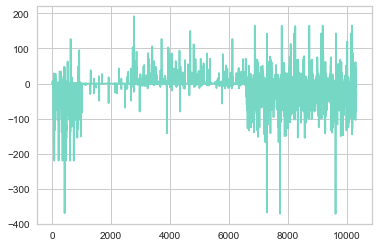

In [47]:
# plot delayed deliveries
(pd.to_numeric(datetime64['delay_t'])/(1e9*3600*24)).plot(color='#76D7C4')

In [48]:
# define new column that will keep deliveries that were late
tobject['delayed_del'] = datetime64['delay_t']>'0 days'
print("\n-Delayed deliveries: \n", tobject.delayed_del.value_counts())
print("\n-Delayed deliveries (%): ",tobject.delayed_del.sum()/len(tobject))


-Delayed deliveries: 
 False    9138
True     1186
Name: delayed_del, dtype: int64

-Delayed deliveries (%):  0.11487795428128632


In [49]:
delayed_df = pd.concat([datetime64[['del_date','delay_t']], 
                      tobject[['itm_desc','vendor', 'manu_site', 'delayed_del']]], axis=1)

#assign
delayed_df['delayed_del'] = delayed_df.delayed_del.map({True:1, False:0})
delayed_df['delay_t'] = delayed_df.delay_t.dt.days

# sort + group features
sorted_values = delayed_df.sort_values(by=['del_date', 'vendor', 'itm_desc']
        , ascending =True)[['del_date', 'vendor', 'itm_desc', 'delayed_del', 'delay_t']].groupby(
                                                                ['del_date', 'vendor', 'itm_desc'])

#aggregate by cumulative sum/min in df
cum_trending = sorted_values.agg(['cumsum', 'cummin']).shift(+1)
cum_trending.columns = ['cumsum_delay',
                        'cummin_delay',
                        'cumsum_del_t',
                        'cummin_delay_days']
cum_trending.head()

,cumsum_delay,cummin_delay,cumsum_del_t,cummin_delay_days
522,NaN,NaN,NaN,NaN
412,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0
2480,0.0,0.0,0.0,0.0


In [50]:
# calculate moving average
sort_delayed = delayed_df.sort_values(by=['del_date', 'vendor', 'itm_desc'])
sort_delayed['delayed_ma'] = sort_delayed['delayed_del'].rolling(20).mean().shift(+1)
sort_delayed['delay_days_ma'] = sort_delayed['delay_t'].rolling(21).mean()

# merge sort_delayed + cum_trending
trending = pd.merge(sort_delayed, cum_trending, how = 'inner'
                    , right_index= True, left_index= True)

# drop columns we don't need
trending = trending.drop(['del_date', 'delay_t',
                          'itm_desc', 'vendor',
                          'manu_site', 'delayed_del'], axis=1).sort_index()
trending.describe()

,delayed_ma,delay_days_ma,cumsum_delay,cummin_delay,cumsum_del_t,cummin_delay_days
count,10304.000000,10304.000000,10323.000000,10323.000000,10323.000000,10323.000000
mean,0.115101,-6.030127,0.165456,0.103943,-8.746585,-6.916788
std,0.151097,14.838693,0.490305,0.305201,38.467538,27.870993
min,0.000000,-147.666667,0.000000,0.000000,-744.000000,-372.000000
25%,0.000000,-9.190476,0.000000,0.000000,-5.000000,-5.000000
50%,0.050000,-2.666667,0.000000,0.000000,0.000000,0.000000
75%,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.900000,117.857143,7.000000,1.000000,329.000000,192.000000


In [51]:
### FEATURE CREATION ###

## Import Logistics Performance Indices data ##
lpi_path = '.../USAID_Data/'
lpi_data = pd.ExcelFile(lpi_path+'International_LPI_from_2007_to_2018.xlsx')
print("lpi_data sheet names: ", lpi_data.sheet_names)

# new column attributes for lpi_data
lpi_col_attr = ['lpi_score',
                'lpi_rank',
                'lpi_% of highest performer',
                'customs_score',
                'customs_rank',
                'infrast_score',
                'infrast_rank',
                'shipment_score',
                'shipment_rank',
                'logistic_score',
                'logistic_rank',
                'tracking_score',
                'tracking_rank',
                'timeliness_score',
                'timeliness_rank']

# standardize data and create list from year sheets
lpi_list = []
for yr in lpi_data.sheet_names:
    lpi_frame =lpi_data.parse(sheet_name=yr).reset_index()
    lpi_frame.columns = lpi_frame.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    lpi_frame.columns = [yr+":"+c+"_"+lpi_frame[c][1] for c in lpi_frame.columns]
    lpi_frame.rename(columns={yr+':'+'level_0_Country':'country',
                              yr+':'+'level_1_Code': 'country_code',
                              yr+':'+'index':'index'}, inplace=True)
    
    lpi_frame = lpi_frame.drop([0,1]) #drop first/second row, because =null/repeats
    
    # standardize data by year
    for col in lpi_frame.columns:
        if "country_code" in col or "_lower bound" in col or "_upper bound" in col or "_Confidence interval" in col: 
            lpi_frame = lpi_frame.drop(columns = [col])
    
    # standardize column names
    attr = 0
    for col in lpi_frame.columns[1:]:
        lpi_frame.rename(columns={col: yr+':'+lpi_col_attr[attr] }, inplace=True)
        attr+=1
    
    print(yr, "columns: ", lpi_frame.shape)
    lpi_list.append(lpi_frame)

lpi_data sheet names:  ['2018', '2016', '2014', '2012', '2010', '2007']
2018 columns:  (160, 16)
2016 columns:  (160, 16)
2014 columns:  (160, 16)
2012 columns:  (155, 16)
2010 columns:  (155, 16)
2007 columns:  (150, 16)


In [52]:
# collect countries in a list
lpi_countries=[]
for d in lpi_list:
    lpi_countries += (list(lpi_list[0].country))
lpi_countries = set(lpi_countries)

# create data frame from lpi_countries 
df_countries = pd.DataFrame([], lpi_countries).reset_index().rename(columns={'index':'country'})

# merge with lpi_list elements
for elem in lpi_list:
    df_countries = df_countries.merge(elem, how='left',left_on='country',right_on='country' )

# switch NaN values in '_score' cols with the avg of the column
for col in df_countries.columns[1:]:
    if "_score" in col:
        m = df_countries[col].mean()
        df_countries[col].fillna(m, inplace=True)    

# fix data for missing year
lpi_cols = list(set([x.split(':')[1] for x in df_countries.columns[1:]]))
mis = ['2008', '2009', '2011', '2013', '2015', '2017']
missing_cols = [x+':'+y for x in mis for y in lpi_cols]
print("missing_cols:", len(missing_cols))

# for every missing year, assign values =avg of the year below and above missing year
missing_col = [x for x in missing_cols if x[:4]=='2008']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] =  df_countries['2007:'+suffix]
            
missing_col = [x for x in missing_cols if x[:4]=='2009']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] = (df_countries['2007:'+suffix] + df_countries['2010:'+suffix])/2.0
psf.rank_missing(df_countries, missing_col)  
    
missing_col = [x for x in missing_cols if x[:4]=='2011']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] = (df_countries['2010:'+suffix] + df_countries['2012:'+suffix])/2.0
psf.rank_missing(df_countries, missing_col)  
    
missing_col = [x for x in missing_cols if x[:4]=='2013']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] = (df_countries['2012:'+suffix] + df_countries['2014:'+suffix])/2.0
psf.rank_missing(df_countries, missing_col)  
    
missing_col = [x for x in missing_cols if x[:4]=='2015']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] = (df_countries['2014:'+suffix] + df_countries['2016:'+suffix])/2.0
psf.rank_missing(df_countries, missing_col)  
    
missing_col = [x for x in missing_cols if x[:4]=='2017']
for row in missing_col:
    suffix = row.split(':')[1]
    df_countries[row] = (df_countries['2018:'+suffix] + df_countries['2016:'+suffix])/2.0
psf.rank_missing(df_countries, missing_col)  

print("df_countries.shape: ", df_countries.shape)

missing_cols: 90
df_countries.shape:  (160, 181)


In [53]:
# create copy of df_countries and trim it
df_countries_copy = df_countries
for col in df_countries_copy.columns[1:]:
    if "_score" not in col: df_countries_copy = df_countries_copy.drop(columns = [col])

# stack countries' result and order
lpi_ordered = df_countries_copy.set_index(['country']).stack().reset_index()
lpi_ordered['year'] = [x[0] for x in lpi_ordered.level_1.str.split(':')]
lpi_ordered['score_type'] = [x[1] for x in lpi_ordered.level_1.str.split(':')]
lpi_ordered.drop('level_1', axis=1, inplace=True)
lpi_ordered.rename(columns={0:'score'}, inplace=True)

# unstack results and sort
lpi_sorted = lpi_ordered.set_index(['country','year', 'score_type']).unstack().reset_index()

#lpi_sorted.to_excel(export_p + 'lpi_sorted_scores_2007-2018.xlsx') #export
print("lpi scores description: \n ", lpi_sorted.describe())

lpi scores description: 
                     score                                            \
score_type customs_score infrast_score logistic_score    lpi_score   
count        1920.000000   1920.000000    1920.000000  1920.000000   
mean            2.659092      2.713909       2.807161     2.862492   
std             0.572473      0.661848       0.589756     0.556607   
min             1.111111      1.100000       1.250000     1.211669   
25%             2.250000      2.247181       2.383932     2.465831   
50%             2.561815      2.574411       2.726806     2.777427   
75%             2.953065      3.082438       3.118317     3.163526   
max             4.207790      4.439356       4.315699     4.225967   

                                                           
score_type shipment_score timeliness_score tracking_score  
count         1920.000000      1920.000000    1920.000000  
mean             2.831632         3.278975       2.873881  
std              0.495399       

In [54]:
## Import Fragile State Index data ##
fsi_path = '.../USAID_Data/FSI_Data/'
fsi_by_year = ['fsi-2007.xlsx',
               'fsi-2008.xlsx',
               'fsi-2009.xlsx',
               'fsi-2010.xlsx',
               'fsi-2011.xlsx',
               'fsi-2012.xlsx',
               'fsi-2013.xlsx',
               'fsi-2014.xlsx',
               'fsi-2015.xlsx',
               'fsi-2016.xlsx',
               'fsi-2017.xlsx',
               'fsi-2018.xlsx']

fsi_excel = [pd.read_excel(pd.ExcelFile(fsi_path+fsi)) for fsi in fsi_by_year]

# create a data frame of year, country and fsi only:
sep_fsi = [d.loc[:,['Country','Year','Total']] for d in fsi_excel]

for df in sep_fsi:
    df['year'] = df['Year'].apply(lambda x: str(x.year))
    df['country'] = df['Country'].str.strip()
    df.rename(columns={'Total':'fsi'}, inplace=True)
    df.drop(['Year', 'Country'], axis=1, inplace=True) #drop old Country and Year columns

# concatenate fsi's and export to excel file
[len(d) for d in sep_fsi]
fsi_data = pd.concat(sep_fsi, axis=0)
fsi_data = fsi_data[['year','country','fsi']] # rearrange columns
#fsi_data.to_excel(fsi_path+'fsi_2007-2018.xlsx')
fsi_data.head(5)

,year,country,fsi
0,2007,Sudan,113.7
1,2007,Iraq,111.4
2,2007,Somalia,111.1
3,2007,Zimbabwe,110.1
4,2007,Chad,108.8


In [55]:
## Compare LPI and FSI ##
fsi_ser = pd.Series(fsi_data['country'].unique(), name='fsi')
lpi_ser = pd.Series(lpi_sorted['country'].unique(), name='lpi')
print("FSI #countries:",len(fsi_ser),"\nLPI #countries:",len(lpi_ser))

lpfs_countries = pd.merge(pd.DataFrame(fsi_ser),pd.DataFrame(lpi_ser), left_on='fsi', right_on='lpi'
         , suffixes=('fsi', 'lpi'), how='outer')

# export lpfs_countries
export_p = '.../USAID_Data/export_data/'
#lpfs_countries.to_excel(export_p+'lpi_fsi_country_comparison.xlsx')
print("lpfs_countries: ", lpfs_countries.shape)

lpi_not_fsi = list(lpfs_countries[lpfs_countries.fsi.isnull()].lpi)
fsi_not_lpi = list(lpfs_countries[lpfs_countries.lpi.isnull()].fsi)
print("#Countries in LPI, not in FSI: ", len(lpi_not_fsi)
      , "\n#Countries in FSI, not in LPI: ", len(fsi_not_lpi))

print("\n\n-Countries in LPI, not in FSI: {} \n\n-Countries in FSI, not in LPI: {}".format(lpi_not_fsi, fsi_not_lpi))

FSI #countries: 178 
LPI #countries: 160
lpfs_countries:  (197, 2)
#Countries in LPI, not in FSI:  19 
#Countries in FSI, not in LPI:  37


-Countries in LPI, not in FSI: ['Bahamas, The', 'Congo, Dem. Rep.', 'Congo, Rep.', "Côte d'Ivoire", 'Egypt, Arab Rep.', 'Gambia, The', 'Guinea-Bissau', 'Hong Kong SAR, China', 'Iran, Islamic Rep.', 'Israel', 'Korea, Rep.', 'Lao PDR', 'Macedonia, FYR', 'Russian Federation', 'Syrian Arab Republic', 'São Tomé and Principe', 'Taiwan, China', 'Venezuela, RB', 'Yemen, Rep.'] 

-Countries in FSI, not in LPI: ["Cote d'Ivoire", 'Congo Democratic Republic', 'North Korea', 'Ethiopia', 'Timor-Leste', 'Yemen', 'Congo Republic', 'Egypt', 'Guinea Bissau', 'Syria', 'Laos', 'Iran', 'Swaziland', 'Azerbaijan', 'Russia', 'Cape Verde', 'Nicaragua', 'Venezuela', 'Israel and West Bank', 'Tanzania', 'Sao Tome and Principe', 'Mozambique', 'Gambia', 'Macedonia', 'Suriname', 'Samoa', 'Micronesia', 'Grenada', 'Namibia', 'Seychelles', 'Belize', 'Botswana', 'Antigua and Barbuda

In [56]:
## Merge LPI and FSI ##
print("\nFSI #countries by year: \n",fsi_data.year.value_counts().sort_index())
print("\nLPI #countries by year: \n",lpi_sorted.year.value_counts().sort_index())

# update lpi data by giving country names from lpi_fsi countries
lpi_sorted['country'].replace({x:y for x,y in zip(lpfs_countries.lpi, lpfs_countries.fsi)}, inplace=True)
print("lpi sorted shape:", lpi_sorted.shape, "\nfsi sorted shape:", fsi_data.shape)

#merge on country and year - don't repeat them
lpi_fsi_merged = pd.merge(fsi_data, lpi_sorted, how='left', left_on=['country', 'year'], 
                          right_on=['country', 'year'])

for i in lpi_fsi_merged.columns[3:]:
    lpi_fsi_merged.rename(columns={i:i[1]}, inplace = True)

lpi_fsi_merged['year'] = pd.to_datetime(lpi_fsi_merged['year'])
lpi_fsi_merged['year'] = [x.year for x in lpi_fsi_merged['year']]
print("Shape after merge: ", lpi_fsi_merged.shape)
#lpi_fsi_merged.to_excel(export_p+'lpi_fsi_merged.xlsx')


FSI #countries by year: 
 2007    177
2008    177
2009    177
2010    177
2011    177
2012    178
2013    178
2014    178
2015    178
2016    178
2017    178
2018    178
Name: year, dtype: int64

LPI #countries by year: 
 2007    160
2008    160
2009    160
2010    160
2011    160
2012    160
2013    160
2014    160
2015    160
2016    160
2017    160
2018    160
Name: year, dtype: int64
lpi sorted shape: (1920, 9) 
fsi sorted shape: (2131, 3)
Shape after merge:  (2131, 10)


C:\Users\Pavel\Miniconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\Pavel\Miniconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Pavel\Miniconda3\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [57]:
## Locate Manufacturing Sites with Google Maps API ##

manu_site = pd.DataFrame(tobject['manu_site'].unique(),columns=['manu_site'] )
site_location = []

# get location of site
for site in manu_site['manu_site']:
    try:
        site_location.append(psf.locateSite(site))
    except IndexError:
        part = site.split()       
        try:
            site_location.append(psf.locateSite(" ".join(part[-3:])))
        except IndexError:            
            try:
                site_location.append(psf.locateSite(" ".join(part[-2:])))
            except IndexError:
                try:
                    site_location.append(psf.locateSite(" ".join(part[-1:])))
                except IndexError:
                    site_location.append(("NaN","NaN","NaN")) # if no address found, write NaN
                    
print("Number of unique manufacturers:", len(manu_site), '\nNumber of unique addresses:', len(site_location))

Number of unique manufacturers: 87 
Number of unique addresses: 87


In [58]:
# check locations
site_location_df = pd.DataFrame(site_location)
manu_site['manufacturer_address'], manu_site['manu_country'], manu_site['manu_continent'] = \
site_location_df[0], site_location_df[1], site_location_df[2]

not_located = manu_site[manu_site['manufacturer_address'] == 'IndexError']['manufacturer_address'].value_counts()
if not_located.empty: not_located = 0
print("Number of not located manufacturers: ", not_located)
manu_site.manu_continent.value_counts()

Number of not located manufacturers:  0


Asia             32
North America    28
Europe           23
Africa            3
Oceania           1
Name: manu_continent, dtype: int64

In [59]:
# trim data frame
manu_site['index'] = manu_site.index
manu_site.head()

,manu_site,manufacturer_address,manu_country,manu_continent,index
0,Ranbaxy Fine Chemicals LTD,"5, Kustia Road, Tiljala, Kustia Road, Kolkata,...",India,Asia,0
1,"Aurobindo Unit III, India","Sy. No. 313, Dr.Reddy's Enclave, Hyderabad, Ba...",India,Asia,1
2,ABBVIE GmbH & Co.KG Wiesbaden,"Mainzer Str. 81, 65189 Wiesbaden, Germany",Germany,Europe,2
3,"Ranbaxy, Paonta Shahib, India","Batamandi, Paonta Sahib, Himachal Pradesh 1730...",India,Asia,3
4,MSD South Granville Australia,"South Granville NSW 2142, Australia",Australia,Oceania,4


In [60]:
# export location of manufacturers
#manu_site.to_csv(export_p+"manufacturing site_continent location.csv")
print("manu_site shape: ",manu_site.shape)
manu_ctrys = list(manu_site['manu_country'])
del_point_ctrys = list(tobject.country)
print("Countries that are manufacturers and delivery points: "
      , sorted([ctry for ctry in manu_ctrys if ctry in del_point_ctrys]))
manu_site = manu_site.drop_duplicates(keep='first') #drop duplicates

manu_site shape:  (87, 5)
Countries that are manufacturers and delivery points:  ['South Africa', 'South Africa', 'South Africa']


In [61]:
tobject = pd.merge(tobject, manu_site, how="left", left_on=['manu_site'], right_on=['manu_site'])
tobject.head()

,p_code,pq,po_so,asn_dn,country,managed_by,flf_via,vendor_terms,ship_mode,pq_client_date,...,rec_del_date_qt,c_ship,sep_weight,sep_freight,cmdty_cost_freight,delayed_del,manufacturer_address,manu_country,manu_continent,index
0,100-CI-T01,Pre-PQ Process,SCMS-4,ASN-8,Côte d'Ivoire,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,2,single_w,No,No,No,False,"5, Kustia Road, Tiljala, Kustia Road, Kolkata,...",India,Asia,0
1,108-VN-T01,Pre-PQ Process,SCMS-13,ASN-85,Vietnam,PMO - US,Direct Drop,EXW,Truck,Pre-PQ Process,...,4,single_w,No,No,No,False,"Sy. No. 313, Dr.Reddy's Enclave, Hyderabad, Ba...",India,Asia,1
2,100-CI-T01,Pre-PQ Process,SCMS-20,ASN-14,Côte d'Ivoire,PMO - US,Direct Drop,FCA,Air,Pre-PQ Process,...,3,single_w,No,No,No,False,"Mainzer Str. 81, 65189 Wiesbaden, Germany",Germany,Europe,2
3,108-VN-T01,Pre-PQ Process,SCMS-78,ASN-50,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,3,single_w,No,No,No,False,"Batamandi, Paonta Sahib, Himachal Pradesh 1730...",India,Asia,3
4,108-VN-T01,Pre-PQ Process,SCMS-81,ASN-55,Vietnam,PMO - US,Direct Drop,EXW,Air,Pre-PQ Process,...,3,batched_top_w,No,No,No,False,"Sy. No. 313, Dr.Reddy's Enclave, Hyderabad, Ba...",India,Asia,1


In [62]:
## Merge Location with LPI and FSI ##
del_point = tobject.groupby(['country', 'sch_del_date_yr']).agg(['count', 'sum', 'mean'])['delayed_del']
del_point.reset_index(inplace=True)
manu_loc = tobject.groupby(['manu_country', 'sch_del_date_yr']).agg(['count', 'sum', 'mean'])['delayed_del']
manu_loc.reset_index(inplace=True)
print("\nDelivery point countries: ",del_point.country.unique()
      , "\nManufacturer countries: ", manu_loc.manu_country.unique())


Delivery point countries:  ['Afghanistan' 'Angola' 'Belize' 'Benin' 'Botswana' 'Burkina Faso'
 'Burundi' 'Cameroon' 'Congo, DRC' "Côte d'Ivoire" 'Dominican Republic'
 'Ethiopia' 'Ghana' 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Kazakhstan'
 'Kenya' 'Kyrgyzstan' 'Lebanon' 'Lesotho' 'Liberia' 'Libya' 'Malawi'
 'Mali' 'Mozambique' 'Namibia' 'Nigeria' 'Pakistan' 'Rwanda' 'Senegal'
 'Sierra Leone' 'South Africa' 'South Sudan' 'Sudan' 'Swaziland'
 'Tanzania' 'Togo' 'Uganda' 'Vietnam' 'Zambia' 'Zimbabwe'] 
Manufacturer countries:  ['Australia' 'Canada' 'China' 'Cyprus' 'France' 'Germany' 'Greece' 'India'
 'Italy' 'Netherlands' 'Norway' 'Poland' 'Puerto Rico' 'South Africa'
 'South Korea' 'Spain' 'Switzerland' 'Thailand' 'United Kingdom'
 'United States']


In [63]:
# compare countries and fix data frames
psf.compare_countries(del_point,lpi_fsi_merged, 'country', 'country')
lpi_fsi_merged['country'].replace({'Congo Democratic Republic':'Congo, DRC',
                                   "Cote d'Ivoire":"Côte d'Ivoire",
                                   'Kyrgyz Republic':'Kyrgyzstan'}, inplace=True)

psf.compare_countries(del_point, lpi_fsi_merged, 'country', 'country') # re-check
psf.compare_countries(manu_loc, lpi_fsi_merged, 'manu_country', 'country')

df1 shape: 43 df2 shape: 178
In df1, not in df2 length: 138 
In df2, not in df1 length: 3
In df1, not in df2: ['Iraq', 'Somalia', 'Chad', "Cote d'Ivoire", 'Congo Democratic Republic', 'Central African Republic', 'North Korea', 'Myanmar', 'Bangladesh', 'Timor-Leste', 'Nepal', 'Uzbekistan', 'Yemen', 'Sri Lanka', 'Congo Republic', 'Solomon Islands', 'Niger', 'Colombia', 'Egypt', 'Guinea Bissau', 'Tajikistan', 'Syria', 'Equatorial Guinea', 'Kyrgyz Republic', 'Turkmenistan', 'Laos', 'Mauritania', 'Bhutan', 'Cambodia', 'Moldova', 'Eritrea', 'Belarus', 'Papua New Guinea', 'Bosnia and Herzegovina', 'Indonesia', 'Philippines', 'Iran', 'Georgia', 'Bolivia', 'Azerbaijan', 'China', 'Russia', 'Cape Verde', 'Maldives', 'Serbia', 'Djibouti', 'Nicaragua', 'Ecuador', 'Venezuela', 'Israel and West Bank', 'Cuba', 'Sao Tome and Principe', 'Comoros', 'Jordan', 'Madagascar', 'Saudi Arabia', 'Peru', 'Gambia', 'Morocco', 'Thailand', 'Algeria', 'Fiji', 'El Salvador', 'Turkey', 'Honduras', 'Macedonia', 'Surinam

,fsi,lpi
0,Australia,Australia
1,Canada,Canada
2,China,China
3,Cyprus,Cyprus
4,France,France
5,Germany,Germany
6,Greece,Greece
7,India,India
8,Italy,Italy
9,Netherlands,Netherlands


In [64]:
lpi_fsi_merged.year = lpi_fsi_merged.year.astype('category')   
del_point_merge = pd.merge(del_point,lpi_fsi_merged, how='left'
           , left_on=['country','sch_del_date_yr'], right_on=['country','year'])
del_point_merge.columns

Index(['country', 'sch_del_date_yr', 'count', 'sum', 'mean', 'year', 'fsi',
       'customs_score', 'infrast_score', 'logistic_score', 'lpi_score',
       'shipment_score', 'timeliness_score', 'tracking_score'],
      dtype='object')

In [65]:
# export mergers of delivery point ctrys and LPI/FSI
lpi_fsi_merged.year = lpi_fsi_merged.year.astype('category')   
del_point_merge = pd.merge(del_point,lpi_fsi_merged, how='left'
           , left_on=['country','sch_del_date_yr'], right_on=['country','year'])

del_point_merge = del_point_merge.drop_duplicates(keep='first')
del_point_merge.drop('year', axis=1, inplace=True)
del_point_merge.columns = ['dp_country',
                           'dp_sch_date_yr',
                           'dp_count',
                           'dp_sum',
                           'dp_mean',
                           'dp_fsi',
                           'dp_customs',
                           'dp_infrast',
                           'dp_logistic',
                           'dp_lpi_score',
                           'dp_shipments',
                           'dp_timeliness',
                           'dp_tracking']

#del_point_merge.to_csv(export_p+'lpi_fsi_destinations.csv')
print(del_point_merge.columns, "\n//del_point_merge description: \n",del_point_merge.describe())

Index(['dp_country', 'dp_sch_date_yr', 'dp_count', 'dp_sum', 'dp_mean',
       'dp_fsi', 'dp_customs', 'dp_infrast', 'dp_logistic', 'dp_lpi_score',
       'dp_shipments', 'dp_timeliness', 'dp_tracking'],
      dtype='object') 
//del_point_merge description: 
        dp_sch_date_yr    dp_count      dp_sum     dp_mean      dp_fsi  \
count      219.000000  219.000000  219.000000  219.000000  209.000000   
mean      2011.027397   47.141553    5.415525    0.092765   88.788038   
std          2.688606   53.276267    9.539677    0.143525   13.593809   
min       2006.000000    1.000000    0.000000    0.000000   62.700000   
25%       2009.000000    6.000000    0.000000    0.000000   76.900000   
50%       2011.000000   30.000000    1.000000    0.013699   89.200000   
75%       2013.000000   74.500000    6.500000    0.153454   99.900000   
max       2015.000000  343.000000   52.000000    1.000000  114.500000   

       dp_customs  dp_infrast  dp_logistic  dp_lpi_score  dp_shipments  \
count  1

In [66]:
# export merger of manufacturer countries and LPI/FSI
manu_loc_merge = pd.merge(manu_loc,lpi_fsi_merged, how='left'
           , left_on=['manu_country','sch_del_date_yr'], right_on=['country','year'])

manu_loc_merge = manu_loc_merge.drop_duplicates(keep='first')
manu_loc_merge.drop('country', axis=1, inplace=True)
manu_loc_merge.drop('year', axis=1, inplace=True)

manu_loc_merge.columns = ['manu_country',
                          'manu_sch_date_yr',
                          'manu_count',
                          'manu_sum',
                          'manu_mean',
                          'manu_fsi',
                          'manu_customs',
                          'manu_infrast',
                          'manu_logistic',
                          'manu_lpi_score',
                          'manu_shipments',
                          'manu_timeliness',
                          'manu_tracking']

#manu_loc_merge.to_csv(export_p+'lpi_fsi_manufacturers.csv')
print(manu_loc_merge.columns,"\n//manu_loc_merge description: \n", manu_loc_merge.describe())

Index(['manu_country', 'manu_sch_date_yr', 'manu_count', 'manu_sum',
       'manu_mean', 'manu_fsi', 'manu_customs', 'manu_infrast',
       'manu_logistic', 'manu_lpi_score', 'manu_shipments', 'manu_timeliness',
       'manu_tracking'],
      dtype='object') 
//manu_loc_merge description: 
        manu_sch_date_yr   manu_count    manu_sum   manu_mean    manu_fsi  \
count        134.000000   134.000000  134.000000  134.000000  122.000000   
mean        2010.604478    77.044776    8.850746    0.026134   45.536066   
std            2.758497   203.134418   35.877718    0.054384   19.823115   
min         2006.000000     1.000000    0.000000    0.000000   16.800000   
25%         2008.000000     3.000000    0.000000    0.000000   31.975000   
50%         2011.000000    13.000000    0.000000    0.000000   36.850000   
75%         2013.000000    46.000000    1.000000    0.021384   66.800000   
max         2015.000000  1162.000000  224.000000    0.295905   84.600000   

       manu_customs  ma

In [67]:
## Consolidate tobject, del_point_merge, manu_loc_merge ##
tobject.sch_del_date_yr =  tobject.sch_del_date_yr.astype('int64') 
del_point_merge.dp_sch_date_yr = del_point_merge.dp_sch_date_yr.astype('int64') 
manu_loc_merge.manu_sch_date_yr = manu_loc_merge.manu_sch_date_yr.astype('int64') 
manu_loc_merge['manu_sch_d_yr'] = manu_loc_merge.manu_sch_date_yr.copy()

del_point_merge, manu_loc_merge = del_point_merge.reset_index(), manu_loc_merge.reset_index()

del_point_merge = del_point_merge.groupby(['dp_country', 'dp_sch_date_yr']).agg('mean')
merge1 = pd.merge(tobject,del_point_merge, how='left',left_on=['country', 'sch_del_date_yr']
         , right_on=['dp_country', 'dp_sch_date_yr'])

manu_loc_merge = manu_loc_merge.groupby(['manu_country', 'manu_sch_date_yr']).agg('mean')
merge2 = pd.merge(merge1, manu_loc_merge, how='left',left_on=['manu_country', 'sch_del_date_yr']
         , right_on=['manu_country', 'manu_sch_d_yr'])

merge2['dp_sch_date_yr'] = merge2.sch_del_date_yr.copy()
merge2.sch_del_date_yr = merge2.sch_del_date_yr.astype('category')

tobject = merge2.copy()
print("Final engineered data shape: ", tobject.shape, "\nColumns: \n", tobject.dtypes)

Final engineered data shape:  (10324, 88) 
Columns: 
 p_code                    object
pq                        object
po_so                     object
asn_dn                    object
country                   object
managed_by                object
flf_via                   object
vendor_terms              object
ship_mode                 object
pq_client_date            object
po_vendor_date            object
product_grp               object
sub_class                 object
vendor                    object
itm_desc                  object
mol_test                  object
brand                     object
dosage                    object
dos_form                  object
manu_site                 object
first_line                object
weight                    object
freight_cost              object
pq_new_date_yr          category
pq_new_date_mn          category
pq_new_date_dy          category
po_new_date_yr          category
po_new_date_mn          category
po_new_date_dy        

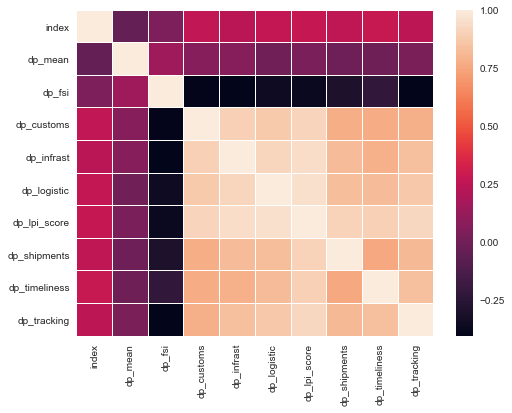

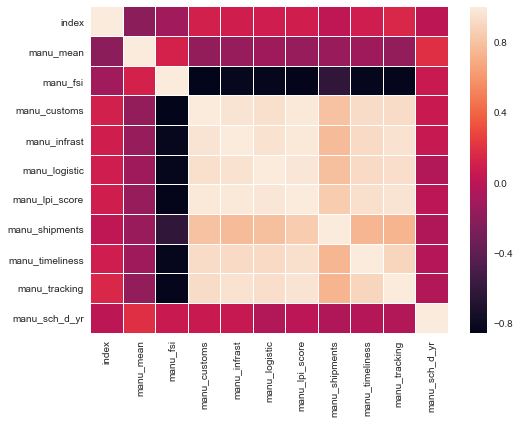

In [68]:
# check correlations in delivery and manu dfs
e1 = [x for x in del_point_merge.columns if ("sum" in x) or ("count" in x)]
corr1=del_point_merge.drop(e1, axis=1)
a, b = plt.subplots(1,1, figsize=(8,6))
#print(corr1.corr())
seaborn.heatmap(corr1.corr(), linewidths=.01)

e2 = [x for x in manu_loc_merge.columns if ("sum" in x) or ("count" in x)]
corr2=manu_loc_merge.drop(e2, axis=1)
f, ax = plt.subplots(1,1, figsize=(8,6))
#print(corr2.corr())
seaborn.heatmap(corr2.corr(), linewidths=.01)

In [69]:
# fill null values wtih col. avg in tobject
tobject_nulls = tobject.isnull().sum()[tobject.isnull().sum()>0].index.tolist()
for c in tobject_nulls:
    try:
        cmean = tobject[c].mean()
        tobject[c].fillna(cmean, inplace=True)
    except:
        pass

# check for nulls
tobject['delayed_del'] = tobject.delayed_del.astype('category')
blocks = tobject.as_blocks()
for key in blocks.keys():
    print("Type: {} , Count: {} \nColumns and null counts: \n{}\n".format(
        key,len(blocks[key].columns),blocks[key].isnull().sum()))

for elem in blocks['object']:
    blocks['object'][elem] = blocks['object'][elem].astype('category')
blocks.keys()

Type: category , Count: 31 
Columns and null counts: 
pq_new_date_yr     0
pq_new_date_mn     0
pq_new_date_dy     0
po_new_date_yr     0
po_new_date_mn     0
po_new_date_dy     0
sch_del_date_yr    0
sch_del_date_mn    0
sch_del_date_dy    0
del_date_yr        0
del_date_mn        0
del_date_dy        0
rec_del_date_yr    0
rec_del_date_mn    0
rec_del_date_dy    0
pq_new_date_wd     0
pq_new_date_wk     0
pq_new_date_qt     0
po_new_date_wd     0
po_new_date_wk     0
po_new_date_qt     0
sch_del_date_wd    0
sch_del_date_wk    0
sch_del_date_qt    0
del_date_wd        0
del_date_wk        0
del_date_qt        0
rec_del_date_wd    0
rec_del_date_wk    0
rec_del_date_qt    0
delayed_del        0
dtype: int64

Type: float64 , Count: 20 
Columns and null counts: 
dp_sum             0
dp_mean            0
dp_fsi             0
dp_customs         0
dp_infrast         0
dp_logistic        0
dp_lpi_score       0
dp_shipments       0
dp_timeliness      0
dp_tracking        0
manu_sum          

C:\Users\Pavel\Miniconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: as_blocks is deprecated and will be removed in a future version
  if sys.path[0] == '':


dict_keys(['category', 'float64', 'int64', 'object'])

In [70]:
ex_cols =['country', 'vendor',
          'manu_site', 'mol_test',
          'brand'] # base columns

# trim from examination columns
for d in [ctry_fs, vendor_fs, manu_site_fs, mol_test_fs, brand_fs]:
    try: 
        d.drop(ex_cols, axis=1, inplace=True)
    except:
        pass
    
# don't repeat duplicates   
ctry=['country_qtycount']+[c for c in ctry_fs.columns if ('sum' in c) or ('mean' in c) or ('yr' in c)]
vendor=['vendor_qtycount']+[c for c in vendor_fs.columns if ('sum' in c) or ('mean' in c) or ('yr' in c)]
manu=['manu_site_qtycount']+[c for c in manu_site_fs.columns if ('sum' in c) or ('mean' in c) or ('yr' in c)]
brand=['brand_qtycount']+[c for c in brand_fs.columns if ('sum' in c) or ('mean' in c) or ('yr' in c)]
mol=['mol_test_qtycount']+[c for c in mol_test_fs.columns if ('sum' in c) or ('mean' in c) or ('yr' in c)]

ctry_fs, manu_site_fs, vendor_fs, brand_fs, mol_test_fs = ctry_fs[ctry], manu_site_fs[manu], vendor_fs[vendor], brand_fs[brand], mol_test_fs[mol]

In [72]:
# merge categorical + objects vars
objects = pd.concat([blocks['category'], blocks['object']], axis=1)

# merge int + float vars
num_log = pd.concat([blocks['float64'], blocks['int64']],axis=1)

# total features
base_exam = [item_desc, ctry_fs,
             vendor_fs, manu_site_fs,
             brand_fs, mol_test_fs,
             num_log, datetime64,
             objects, trending]

b_indices = ['item_desc','ctry_fs',
             'vendor_fs', 'manu_site_fs',
             'brand_fs', 'mol_test_fs',
             'num_log', 'datetime64',
             'objects', 'trending']

In [78]:
# trim data frames
det_feat = [ctry_fs, vendor_fs, manu_site_fs, brand_fs, mol_test_fs, item_desc]
for f in det_feat:
    try:
        f.drop(['sch_del_date_yr'], axis=1, inplace=True)
    except:
            pass

item_desc.rename(columns={'line_item': 'line_item_ins'}, inplace=True)
item_desc.drop(['id'], axis=1, inplace=True)

num_log.drop(['index','index_x','index_y'], axis=1, inplace=True)

In [155]:
feat_path = '.../USAID_Data/'
# export total features
for i in range(len(b_indices)):
    e = str(i)+"_examine_"+b_indices[i]+".csv"
    #base_exam[i].to_csv(feat_path + 'examination features/' + e)

In [94]:
for i in range(len(b_indices)):
    print("\n", b_indices[i], ": ", base_exam[i].shape, "\n\n", base_exam[i].dtypes)


 item_desc :  (10324, 8) 

 unit_msr           int64
ln_itm_qty         int64
ln_itm_val       float64
pack_price       float64
unit_price       float64
line_item_ins    float64
real_w           float64
real_fc          float64
dtype: object

 ctry_fs :  (10324, 11) 

 country_qtycount      int64
country_qtysum        int64
country_qtymean     float64
country_valsum      float64
country_valmean     float64
country_itemsum     float64
country_itemmean    float64
country_wsum        float64
country_wmean       float64
country_fcsum       float64
country_fcmean      float64
dtype: object

 vendor_fs :  (10324, 11) 

 vendor_qtycount      int64
vendor_qtysum        int64
vendor_qtymean     float64
vendor_valsum      float64
vendor_valmean     float64
vendor_itemsum     float64
vendor_itemmean    float64
vendor_wsum        float64
vendor_wmean       float64
vendor_fcsum       float64
vendor_fcmean      float64
dtype: object

 manu_site_fs :  (10324, 11) 

 manu_site_qtycount      int64
man

In [6]:
# train-test data split
from sklearn.model_selection import train_test_split

conc_data = pd.concat([item_desc, ctry_fs, vendor_fs, manu_site_fs
                      , brand_fs, mol_test_fs, num_log, datetime64 
                      , objects, trending], axis=1)

#train_data, test_data = train_test_split(conc_data, test_size=0.2, random_state=88)
train_data, test_data = [df.reset_index(drop=True) for df in (train_data, test_data)]

In [7]:
# train-test features
tr_feat_names = ['item_desc_tr', 'ctry_tr',
                 'vendor_tr', 'manu_site_tr',
                 'brand_tr', 'mol_test_tr',
                 'num_log_tr', 'datetime64_tr',
                 'objects_tr', 'trending_tr']

ts_feat_names = ['item_desc_ts', 'ctry_ts',
                 'vendor_ts', 'manu_site_ts',
                 'brand_ts', 'mol_test_ts',
                 'num_log_ts', 'datetime64_ts',
                 'objects_ts', 'trending_ts']

In [8]:
# split tran/test data to features
train_dict = psf.split_to_features(train_data, base_exam, tr_feat_names)

item_desc_tr, ctry_tr, vendor_tr, manu_site_tr, brand_tr, mol_test_tr\
        , num_log_tr, datetime64_tr, objects_tr, trending_tr = [train_dict[tf] for tf in tr_feat_names] 

test_dict = psf.split_to_features(test_data, base_exam, ts_feat_names)

item_desc_ts, ctry_ts, vendor_ts, manu_site_ts, brand_ts, mol_test_ts\
        , num_log_ts, datetime64_ts, objects_ts, trending_ts = [test_dict[tf] for tf in ts_feat_names]

In [22]:
# export train features
train_features = [item_desc_tr, ctry_tr,
                  vendor_tr, manu_site_tr,
                  brand_tr, mol_test_tr,
                  num_log_tr, datetime64_tr,
                  objects_tr,trending_tr]

for i in range(len(tr_feat_names)):
    #train_features[i].to_csv(feat_path + 'train_test/train/' + tr_feat_names[i] + ".csv")

    
# export test features
test_features = [item_desc_ts, ctry_ts,
                 vendor_ts, manu_site_ts,
                 brand_ts, mol_test_ts,
                 num_log_ts, datetime64_ts,
                 objects_ts, trending_ts]

for i in range(len(ts_feat_names)):
    #test_features[i].to_csv(feat_path + 'train_test/test/' + ts_feat_names[i] + ".csv")